# 1 - Imports

In [1]:
import pandas as pd
import inflection
import calendar
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from tabulate import tabulate
from pycorrcat.pycorrcat import corr_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from boruta import BorutaPy
from warnings import filterwarnings

/home/jhonatan/.pyenv/versions/3.8.0/envs/dsemproducao/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
filterwarnings('ignore')

pd.set_option('display.max_columns', None)

%matplotlib inline

plt.style.use( 'ggplot' )
plt.rcParams['figure.figsize'] = [18, 8]

sns.set;

## 1.1 - Funções

In [97]:
def ml_error(model_name, y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    data = {'model_name': model_name, 'MAE':mae, 'MAPE':mape, 'RMSE':rmse}
    df = pd.DataFrame(data, index=[0])
    
    return df


def cross_validation(modelo, model_name, x_training, k_fold, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in range(1, k_fold+1):
        if verbose:
            print(k)
        # Data inicial e final para validação 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtrando o dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= 
                                                                                         validation_end_date)]

        # Dataset de treino e validação
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # modelo
        model = modelo.fit(xtraining, ytraining)

        # predição
        y_pred_model = model.predict(xvalidation)

        # perfomance
        resultado = ml_error('Linear Regression Model', np.expm1(yvalidation), np.expm1(y_pred_model))
        mae_list.append(resultado['MAE'])
        mape_list.append(resultado['MAPE'])
        rmse_list.append(resultado['RMSE'])

    mean_mae = np.round(np.mean(mae_list),2)
    mean_mape = np.round(np.mean(mape_list),2)
    mean_rmse = np.round(np.mean(rmse_list),2)

    std_mae = np.round(np.std(mae_list),2)
    std_mape = np.round(np.std(mape_list),2)
    std_rmse = np.round(np.std(rmse_list),2)

    mae = 'mean: ' + mean_mae.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_mae.astype(str)
    mape = 'mean: ' + mean_mape.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_mape.astype(str)
    rmse = 'mean: ' + mean_rmse.astype(str) + ' | ' + 'std: ' + ' +/- ' + std_rmse.astype(str)

    data = {'model_name': model_name, 'MAE CV':mae, 'MAPE CV':mape, 'RMSE CV':rmse}
    df = pd.DataFrame(data, index=[0])
    return df

## 1.2 - Carregando os dados

In [4]:
store = pd.read_csv('dados/store.csv', low_memory=False)
train = pd.read_csv('dados/train.csv', low_memory=False)

# Merge
df = pd.merge(store,train, how='left', on='Store')

In [5]:
df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1


# 2 - Descrição dos dados

In [6]:
df1 = df.copy()

## 2.1 - Renomear as colunas

In [7]:
old_name = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'DayOfWeek',
'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday',
'SchoolHoliday']

snakecase = lambda x: inflection.underscore(x)
new_name = list(map(snakecase, old_name))

# Renomear colunas
df1.columns = new_name

In [8]:
print(f'Quantidade de colunas: {df1.shape[0]}')
print(f'Quantidade de linhas: {df1.shape[1]}')

Quantidade de colunas: 1017209
Quantidade de linhas: 18


## 2.2 - Tipo dos dados

In [9]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
dtype: object

## 2.3 - Dados nulos

In [10]:
df1.isnull().sum()

store                                0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
dtype: int64

## 2.4 - Corrigindo os dados nulos

In [11]:
# competition_distance
df1['competition_distance'].fillna(200000, inplace=True)

#competition_open_since_month
df1['competition_open_since_month'].fillna(df1['date'].dt.month, inplace=True)

#competition_open_since_year
df1['competition_open_since_year'].fillna(df1['date'].dt.year, inplace=True)

#promo2_since_week
df1['promo2_since_week'].fillna(df1['date'].dt.week, inplace=True)

#promo2_since_year
df1['promo2_since_year'].fillna(df1['date'].dt.year, inplace=True)

#promo_interval
df1['promo_interval'].fillna(0, inplace=True)

month_map = dict(enumerate(calendar.month_abbr))

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['month_map', 'promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if 
                                                        x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1)

In [12]:
df1.isnull().sum()

store                           0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.5 - Alterar o tipo dos dados

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [14]:
df1.dtypes

store                                    int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
month_map                               object
is_promo                                 int64
dtype: object

## 2.6 -  Análise descritiva

In [15]:
num = df1.select_dtypes(include=['int64', 'float64'])
cat = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.6.1 - Análise numérica

In [16]:
# Tendência central(média e mediana) e dispersão (min, max, percentis, std, skew e kurtosis)
desc = num.describe().T
median = pd.DataFrame( num.apply( np.median ) )
range_ = pd.DataFrame( num.apply( lambda x: x.max() - x.min() ) )
skew = pd.DataFrame( num.apply( lambda x: x.skew() ) )
kurtosis = pd.DataFrame( num.apply( lambda x: x.kurtosis() ) )

desc.insert(2,'median', median[0].values)
desc.insert(len(desc.columns),'range', range_[0].values)
std = desc.pop('std')
desc.insert(len(desc.columns),'std', std)
desc.insert(len(desc.columns),'skew', skew[0].values)
desc.insert(len(desc.columns),'kurtosis', kurtosis[0].values)

desc

,count,mean,median,min,25%,50%,75%,max,range,std,skew,kurtosis
store,1017209.0,558.429727,558.0,1.0,280.0,558.0,838.0,1115.0,1114.0,321.908651,-0.000955,-1.200524
competition_distance,1017209.0,5935.442677,2330.0,20.0,710.0,2330.0,6910.0,200000.0,199980.0,12547.652996,10.242344,147.789712
competition_open_since_month,1017209.0,6.786849,7.0,1.0,4.0,7.0,10.0,12.0,11.0,3.311087,-0.042076,-1.232607
competition_open_since_year,1017209.0,2010.324840,2012.0,1900.0,2008.0,2012.0,2014.0,2015.0,115.0,5.515593,-7.235657,124.071304
promo2,1017209.0,0.500564,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.500000,-0.002255,-1.999999
promo2_since_week,1017209.0,23.619033,22.0,1.0,12.0,22.0,37.0,52.0,51.0,14.310064,0.178723,-1.184046
promo2_since_year,1017209.0,2012.793297,2013.0,2009.0,2012.0,2013.0,2014.0,2015.0,6.0,1.662658,-0.784436,-0.210075
day_of_week,1017209.0,3.998341,4.0,1.0,2.0,4.0,6.0,7.0,6.0,1.997391,0.001593,-1.246873
sales,1017209.0,5773.818972,5744.0,0.0,3727.0,5744.0,7856.0,41551.0,41551.0,3849.926175,0.641460,1.778375
customers,1017209.0,633.145946,609.0,0.0,405.0,609.0,837.0,7388.0,7388.0,464.411734,1.598650,7.091773


### 2.6.2 - Análise categórica

In [17]:
cat.apply(lambda x: x.unique().shape[0])

store_type         4
assortment         3
promo_interval     4
state_holiday      4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

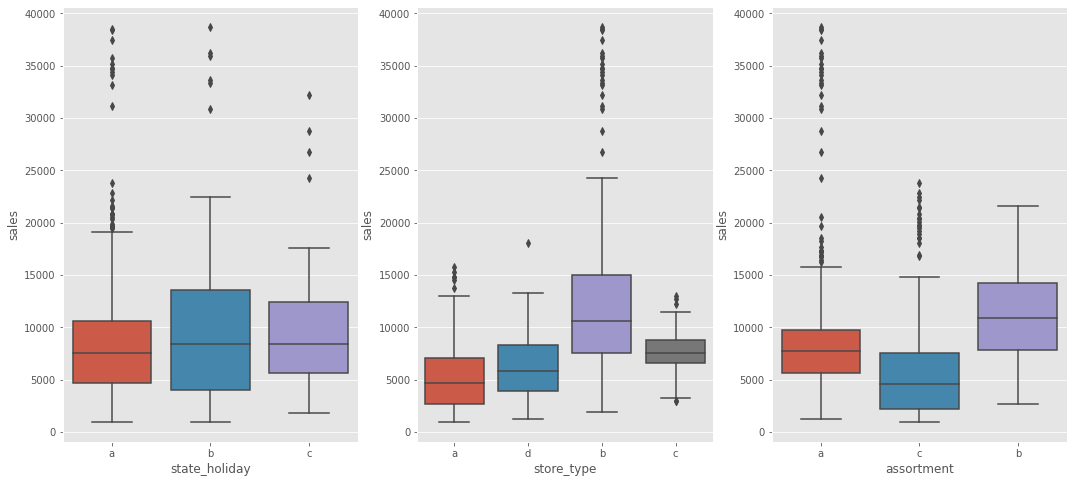

In [18]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]


plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)
plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)
plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)

# 3 - Feature Engineering

## 3.1 - Mapa mental das hipóteses

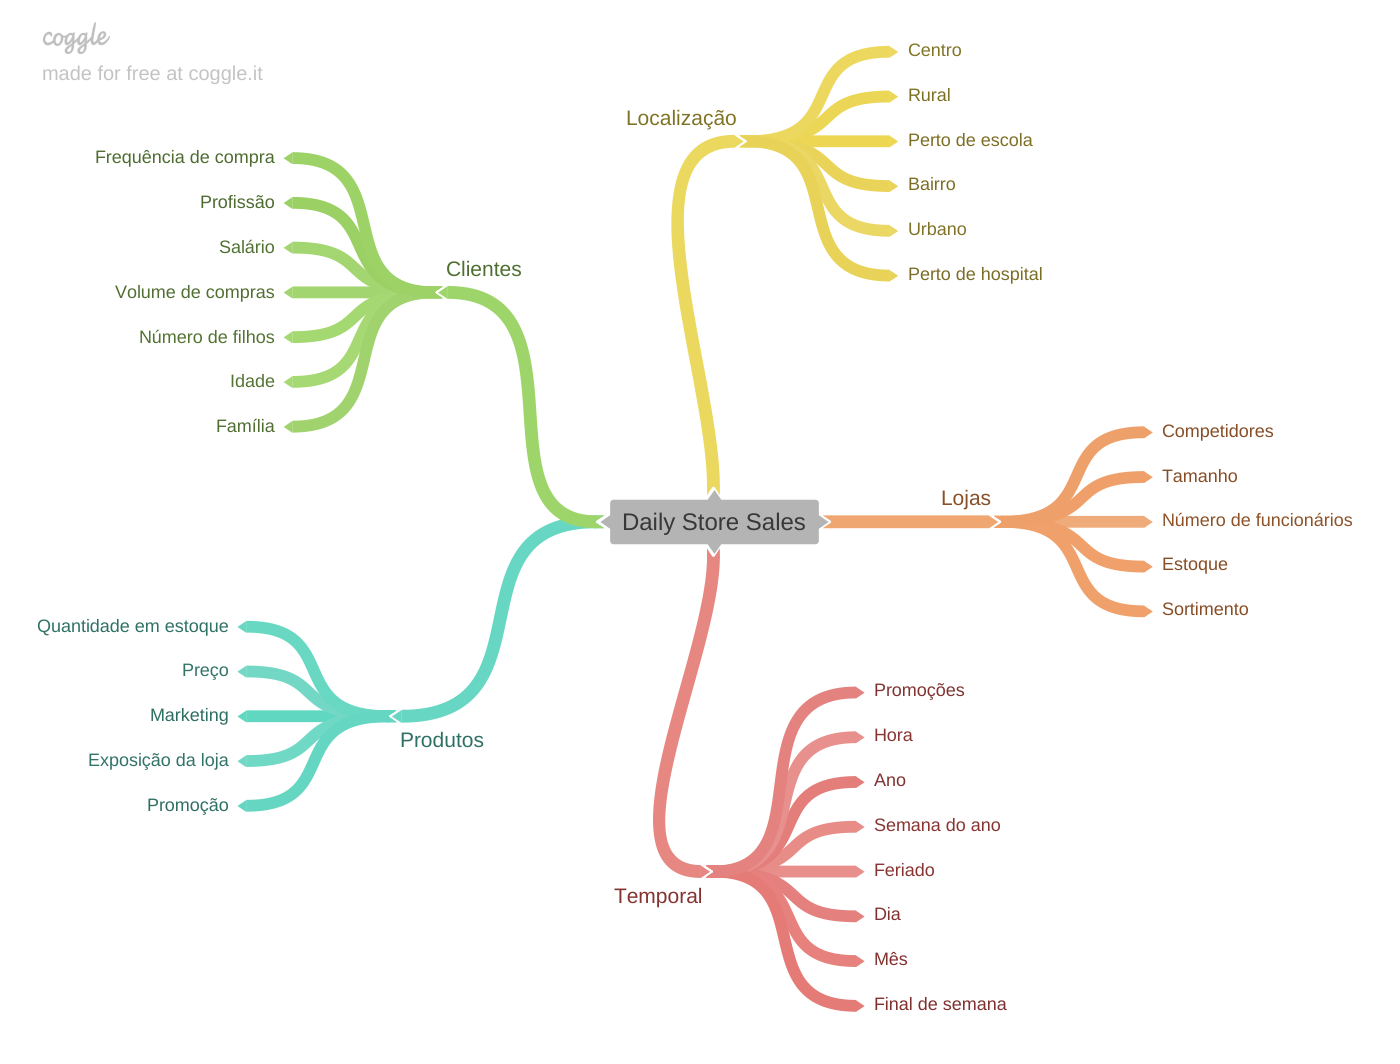

In [19]:
Image('img/hipoteses_mindmap.png', width=650, height=1150)

## 3.2 - Criação das hipóteses

### 3.2.1 - Hipótese da loja

**1.** Loja com maior número de funcionários deveriam vender mais.  

**2.** Lojas com maior capacidade de estoque deveriam vender mais.   

**3.** Lojas com maior porte deveriam vender mais.  

**4.** Lojas com maior sortimentos deveriam vender mais.  

**5.** Lojas com competidores mais próximos deveriam vender menos.  

**6.** Lojas com competidores à mais tempo deveriam vendem mais.  

### 3.2.2 - Hipótese do produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 3.2.3 - Hipótese do tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 3.3 - Lista final de hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

In [20]:
df2 = df1.copy()

### 3.4 - Feature engineering

In [21]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - 
                                                                                      datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'
                                                 else 'christmas' if x == 'c' else 'regular_day')

# 4 - Filtragem das variáveis

In [22]:
df3 = df2.copy()

## 4.1 - Filtragem das linhas

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 4.2 - Seleção das colunas

In [24]:
df3.drop(['customers', 'open', 'promo_interval', 'month_map'], axis=1, inplace=True)

# 5 - Análise exploratória dos dados

In [25]:
df4 = df3.copy()

## 5.1 - Análise univariada

### 5.1.1 - Variável resposta

<AxesSubplot:xlabel='sales', ylabel='Density'>

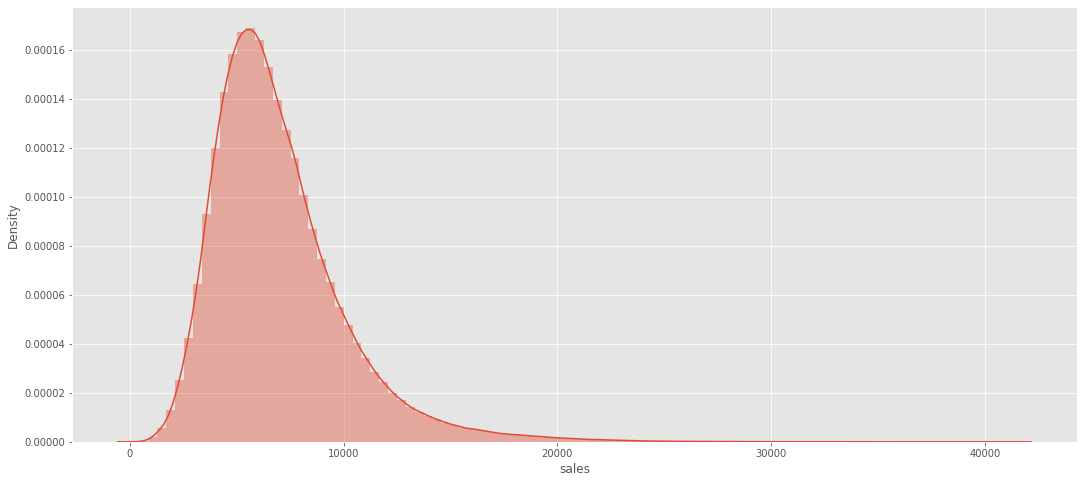

In [26]:
sns.distplot(df4['sales'], bins=100, kde=True)

### 5.1.2 - Variáveis numéricas

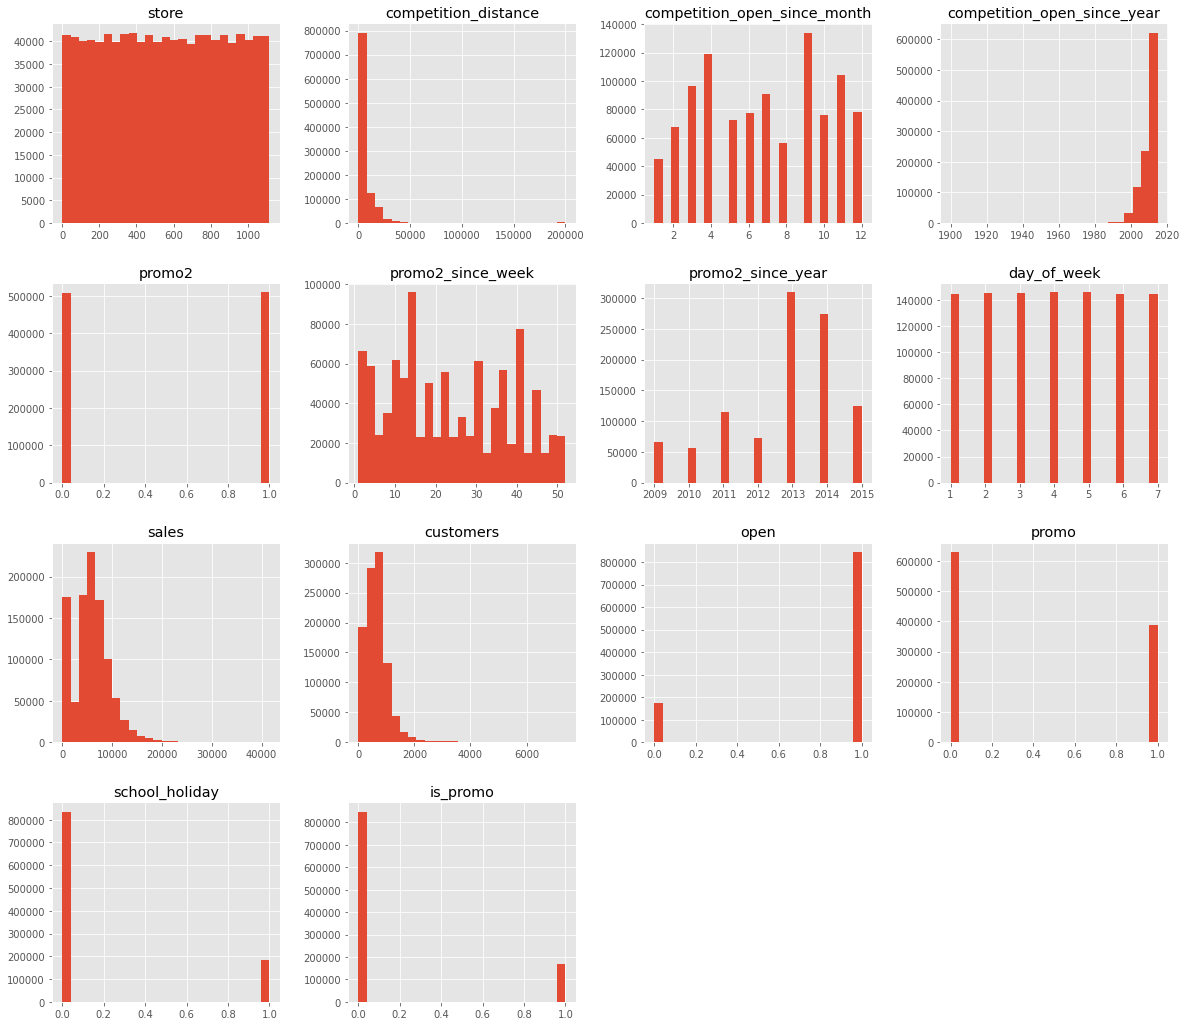

In [27]:
num.hist(figsize=(20,18), bins=25);

### 5.1.3 - Variáveis categóricas

In [28]:
df4['assortment'].value_counts()

basic       444875
extended    391254
extra         8209
Name: assortment, dtype: int64

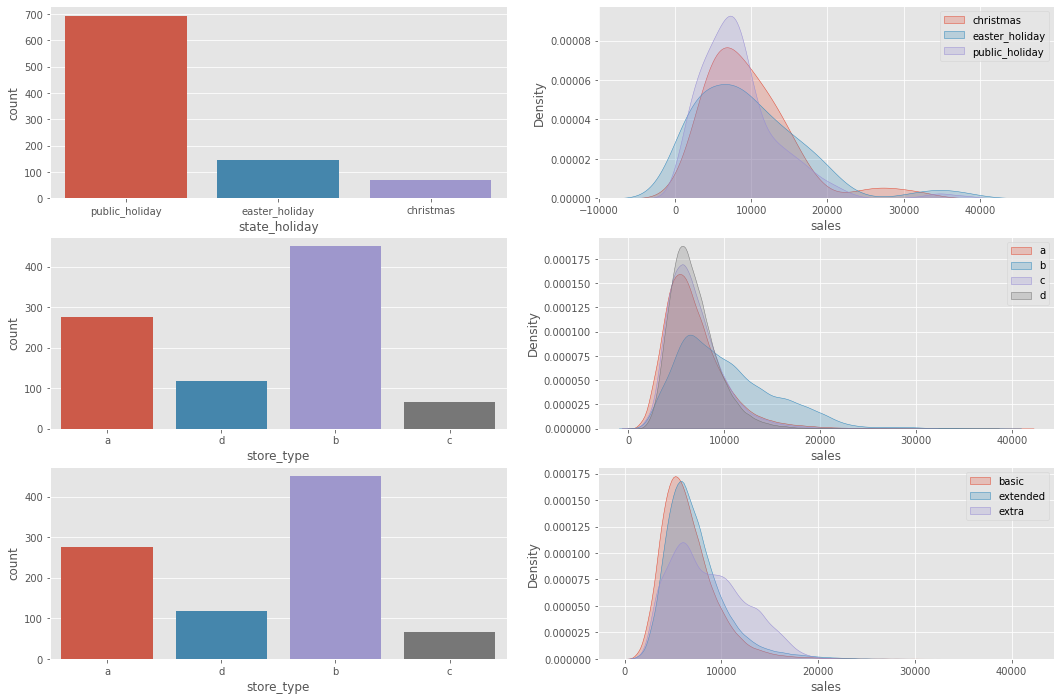

In [29]:
plt.figure(figsize=(18,12))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3, 2, 1)
sns.countplot(aux['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()

plt.subplot(3, 2, 3)
sns.countplot(aux['store_type'])

plt.subplot(3, 2, 4)
df4.sort_values('store_type')
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)
plt.ticklabel_format(style='plain', axis='y')
plt.legend()

plt.subplot(3, 2, 5)
sns.countplot(aux['store_type'])

plt.subplot(3, 2, 6)
df4.sort_values('assortment')
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

plt.ticklabel_format(style='plain', axis='y')
plt.legend();

## 5.2 - Análise bivariada

### Hipótese 1. Lojas com maior sortimentos deveriam vender mais.
**Falso**, pois lojas com maior sortimento (extended) vendem menos que o extra


In [30]:
df4.groupby('assortment', as_index=False).size()

,assortment,size
0,basic,444875
1,extended,391254
2,extra,8209


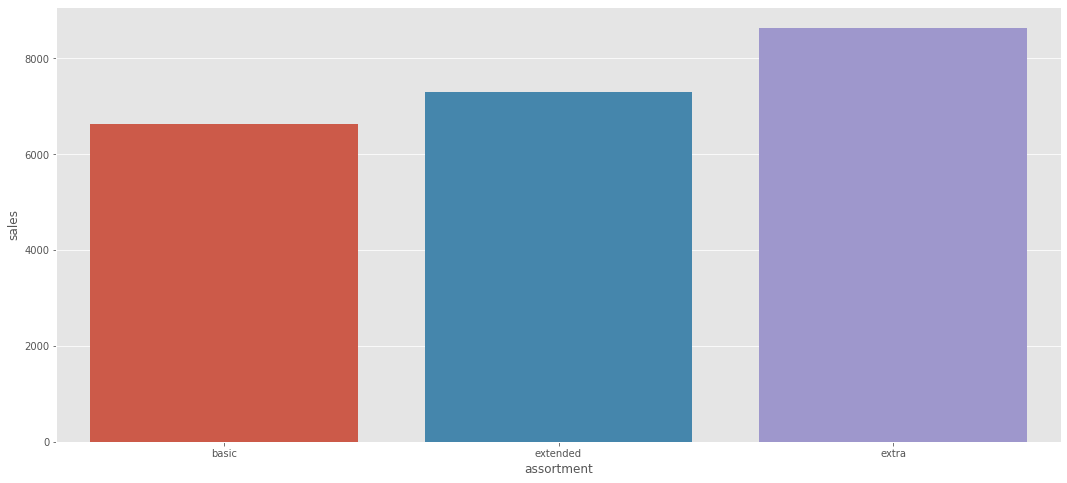

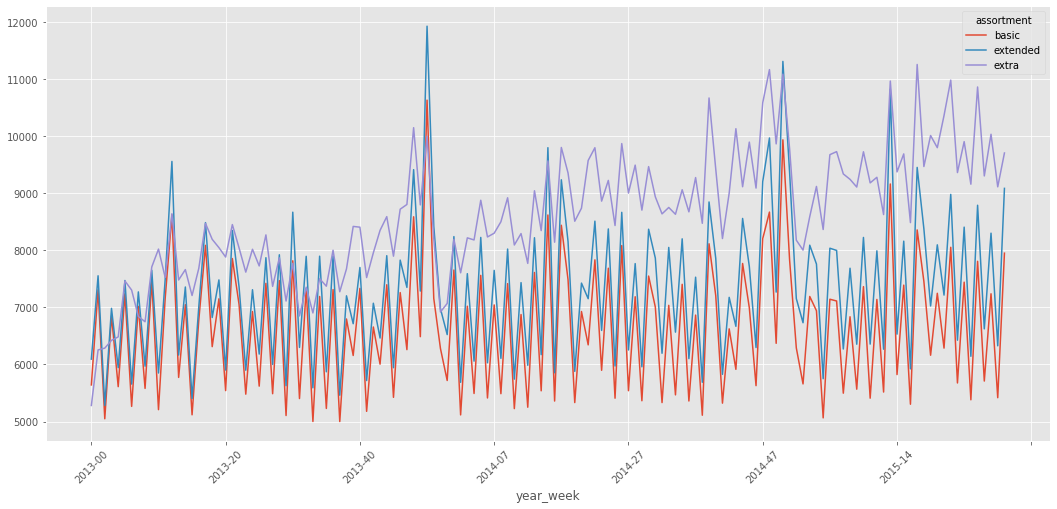

In [31]:
aux = df4.groupby('assortment', as_index=False)['sales'].mean()
sns.barplot(x='assortment', y='sales', data=aux);

aux1 = df4.groupby(['year_week', 'assortment'], as_index=False)['sales'].mean()
aux1.pivot( index='year_week', columns='assortment', values='sales' ).plot()
plt.xticks(rotation=45);


### Hipótese 2. Lojas com competidores mais próximos deveriam vender menos.
**Falsa**, pois quanto mais próximo os competidores, maior as vendas

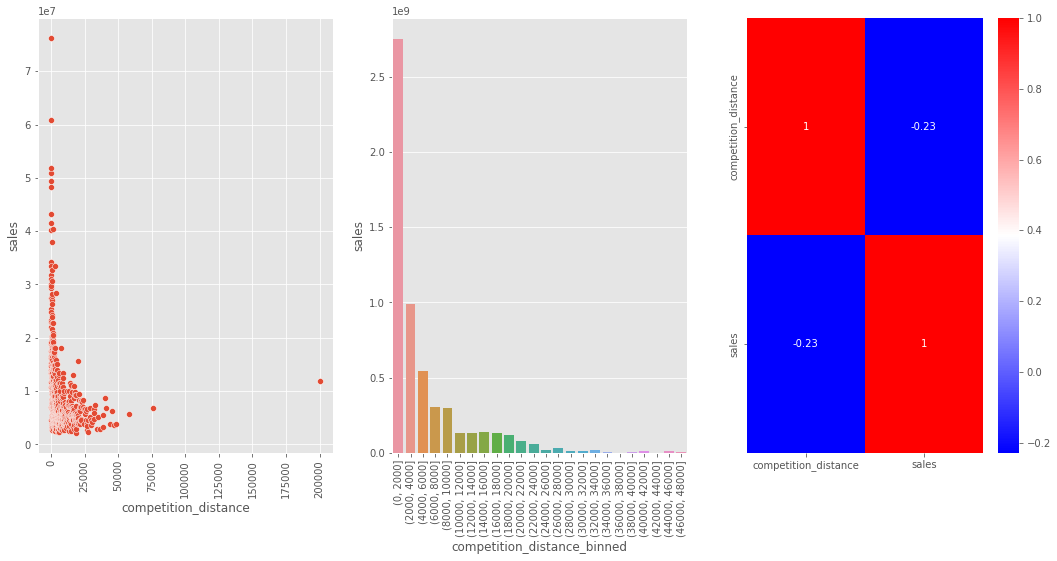

In [32]:
aux = df4.groupby('competition_distance', as_index=False)['sales'].sum()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
bins = list((np.arange(0, 50000, 2000)))
aux['competition_distance_binned'] = pd.cut(aux['competition_distance'], 
                                                                                                                bins=bins)
aux1 = aux.groupby('competition_distance_binned', as_index=False)['sales'].sum()
sns.barplot(x='competition_distance_binned', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(), annot=True, cmap='bwr');

### Hipótese 3. Lojas com competidores à mais tempo deveriam vendem mais.
**Falsa**, pois lojas com competidores abertos há mais tempo vendem menos

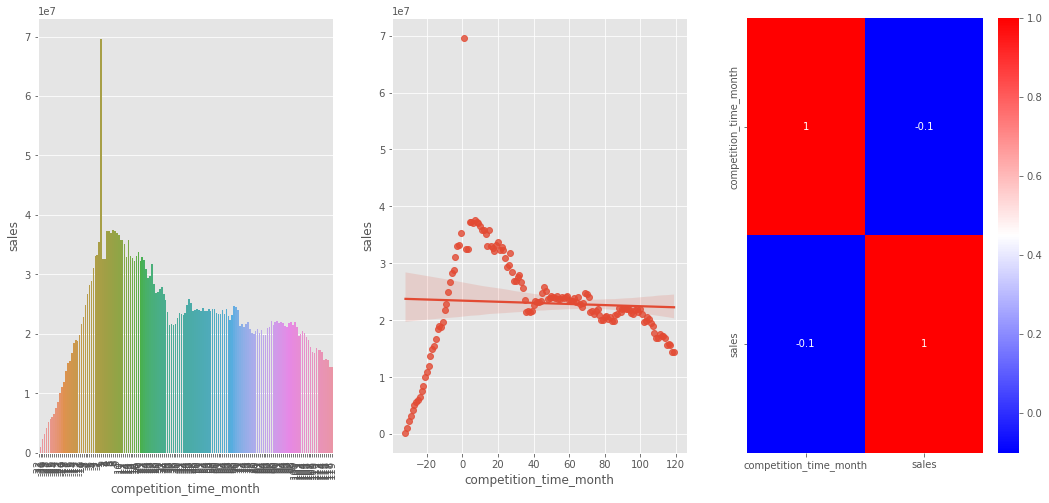

In [33]:
aux = df4.groupby('competition_time_month', as_index=False)['sales'].sum()
aux1 = aux[(aux['competition_time_month'] < 120) & (aux['competition_time_month'] != 0)]

plt.subplot(1,3,1)
sns.barplot(x='competition_time_month', y='sales', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(), annot=True, cmap='bwr');

### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa**, pois as vendas vão caindo conforme o passar do período

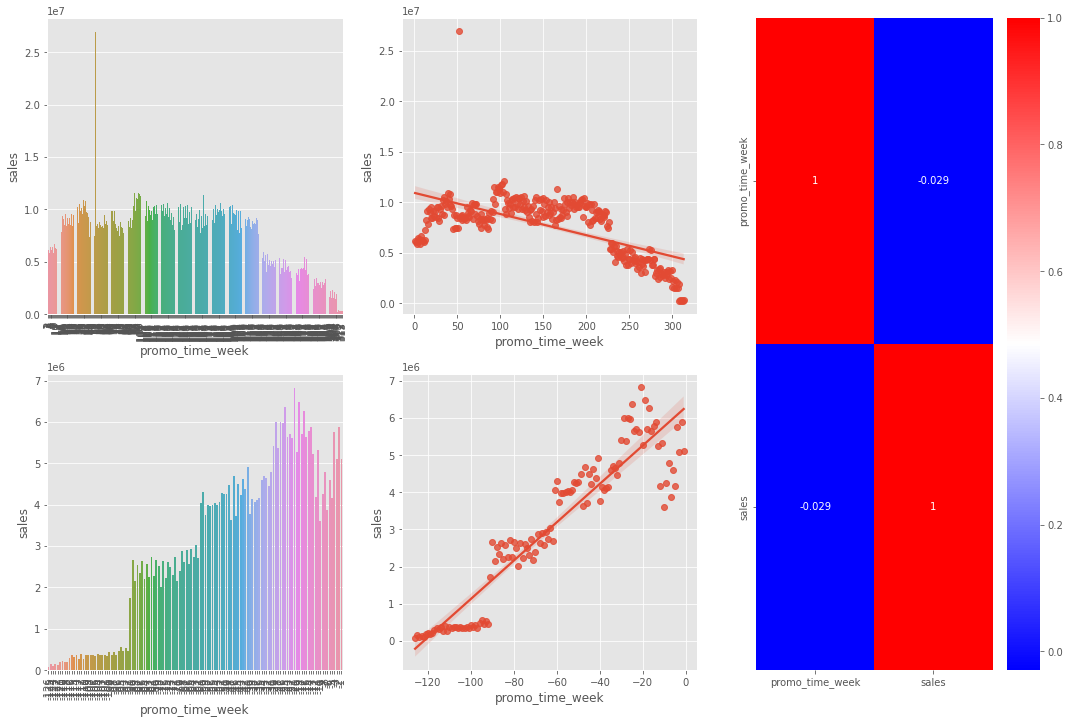

In [34]:
aux = df4.groupby('promo_time_week', as_index=False)['sales'].sum()

positive_promo = aux[aux['promo_time_week'] > 0]
negative_promo = aux[aux['promo_time_week'] < 0]

grid = plt.GridSpec(2, 3)
plt.figure(figsize=(18,12))

plt.subplot(grid[0, 0])
sns.barplot(x='promo_time_week', y='sales', data=positive_promo)
plt.xticks(rotation=90)

plt.subplot(grid[1, 0])
sns.barplot(x='promo_time_week', y='sales', data=negative_promo)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=positive_promo)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=negative_promo)

plt.subplot(grid[:, 2])
sns.heatmap(aux.corr(), annot=True, cmap='bwr');

### <s>5. Lojas com mais dias de promoção deveriam vender mais.</s>

### 6. Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa**, pois lojas com promoções consecutivas vendem menos que apenas uma promoção

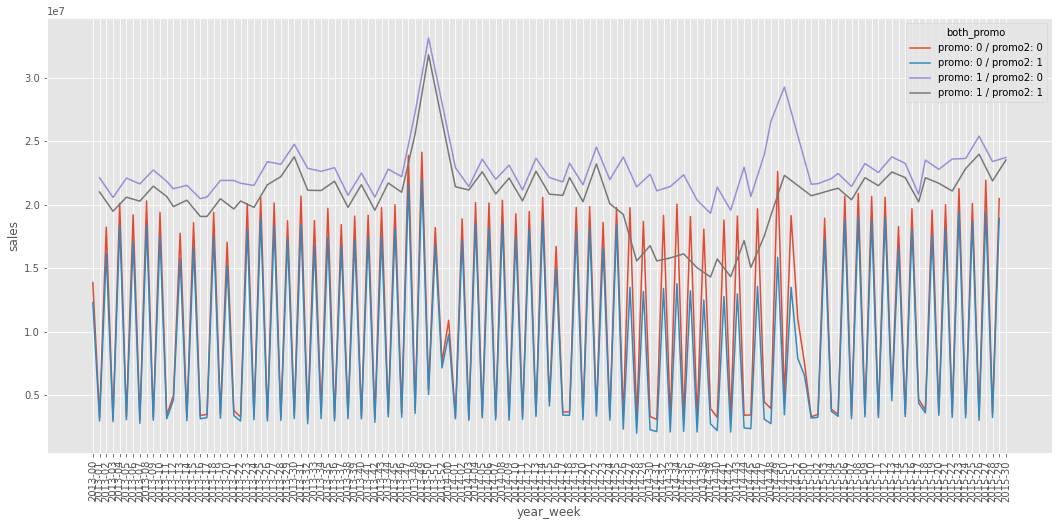

In [35]:
aux = df4.groupby(['promo', 'promo2', 'year_week'], as_index=False)['sales'].sum()
aux['both_promo'] = 'promo: ' + aux['promo'].astype(str) + ' / ' + 'promo2: ' + aux['promo2'].astype(str)
sns.lineplot(x='year_week', y='sales', hue='both_promo', data=aux)
plt.xticks(rotation=90);

### 7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa**, pois o natal é o feriado que menos vende

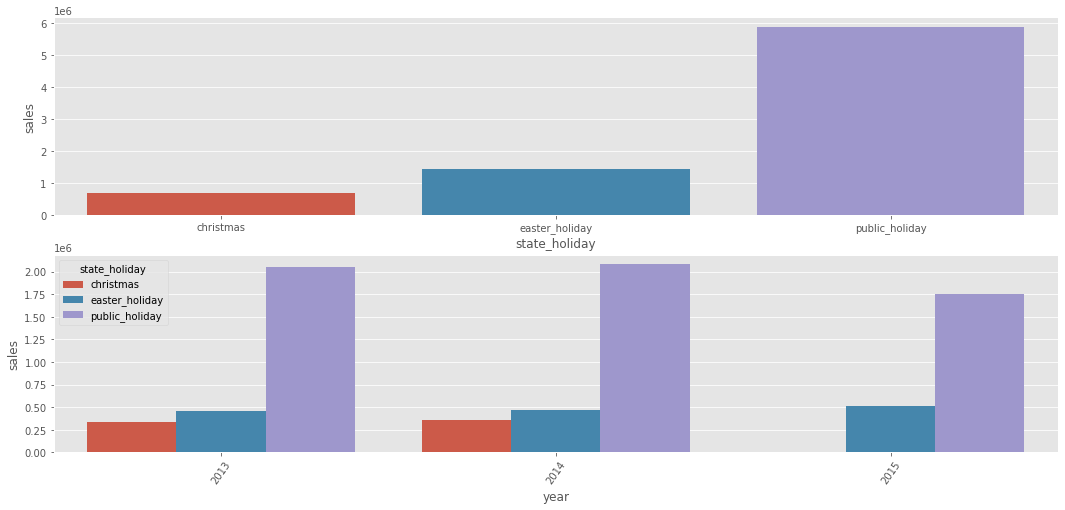

In [36]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux.groupby('state_holiday', as_index=False)['sales'].sum()

plt.subplot(2, 1, 1)
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(2, 1, 2)
aux1 = aux.groupby(['year', 'state_holiday'], as_index=False)['sales'].sum()
sns.barplot(x='year', y='sales', data=aux1, hue='state_holiday')
plt.xticks(rotation=55);

### 8. Lojas deveriam vender mais ao longo dos anos.
**Falsa**, pois mesmo o ano de 2015 não estar inteiro, vemos que houve menos venda em 2014 comparado com 2013

<AxesSubplot:>

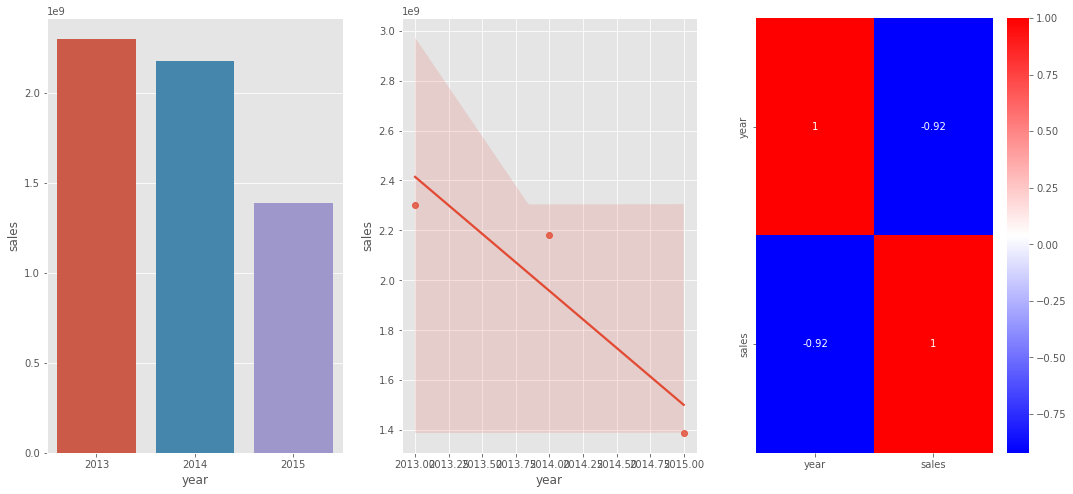

In [37]:
aux = df4.groupby('year', as_index=False)['sales'].sum()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(), annot=True, cmap='bwr')

### 9. Lojas deveriam vender mais no segundo semestre do ano.
**Verdadeiro**, pois o segundo semestre vendeu 932380 a mais que o primeiro, somando os anos de 2013 e 2014, pois 2015 não está completo

            semestre       sales
0  primeiro_semestre  2241374300
1   segundo_semestre  2242306680


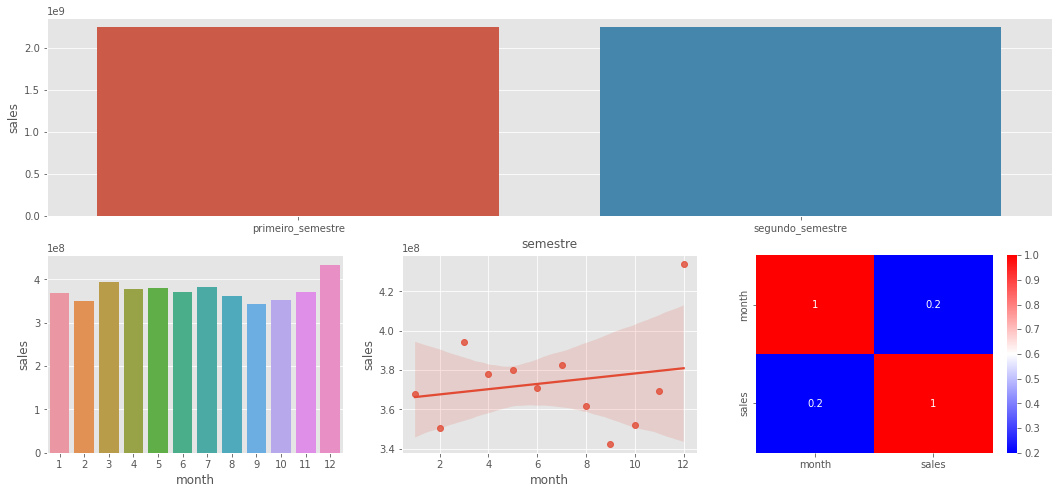

In [38]:
aux = df4[df4['year'] != 2015]
aux['semestre'] = aux['month'].apply(lambda x: 'primeiro_semestre' if x <= 6 else 'segundo_semestre')
aux1 = aux.groupby('month', as_index=False)['sales'].sum()

gird = plt.GridSpec(1, 2)

plt.subplot(grid[1, 0])
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(grid[1, 1])
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(grid[1, 2])
sns.heatmap(aux1.corr(), annot=True, cmap='bwr')

aux2 = aux.groupby('semestre', as_index=False)['sales'].sum()

plt.subplot(grid[0, :])
sns.barplot(x='semestre', y='sales', data=aux2)
print(aux2);

In [39]:
aux2['sales'][1] - aux2['sales'][0]

932380

### 10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeiro**, pois há mais vendas após o dia 10, porém, no dia-a-dia, as datas oscilam

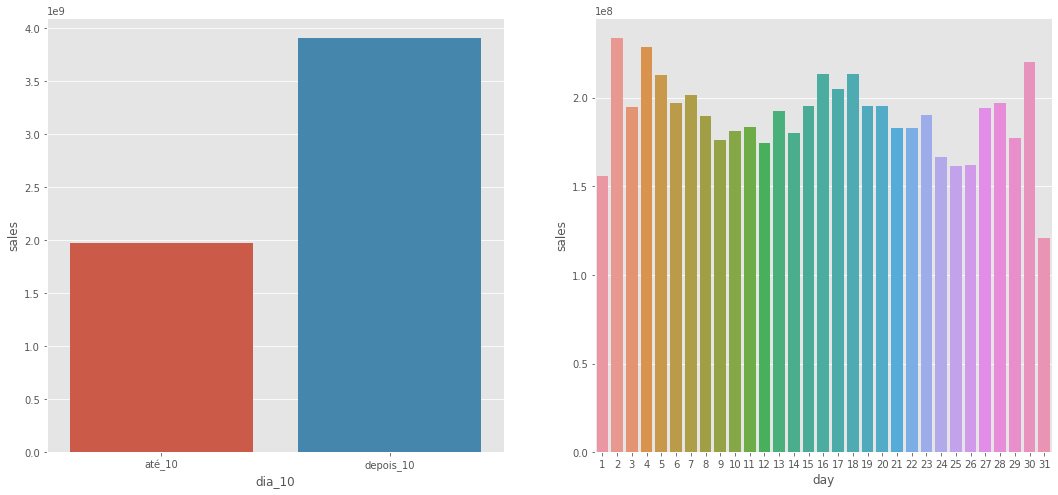

In [40]:
aux = df4.copy()
aux['dia_10'] = aux['day'].apply(lambda x: 'até_10' if x <= 10 else 'depois_10')
aux1 = aux.groupby('dia_10', as_index=False)['sales'].sum()

plt.subplot(1, 2, 1)
sns.barplot(x='dia_10', y='sales', data=aux1)

aux2 = aux.groupby('day', as_index=False)['sales'].sum()

plt.subplot(1, 2, 2)
sns.barplot(x='day', y='sales', data=aux2);

### 11. Lojas deveriam vender menos aos finais de semana.
**Verdadeiro**, pois as vendas são menores aos finais de semana

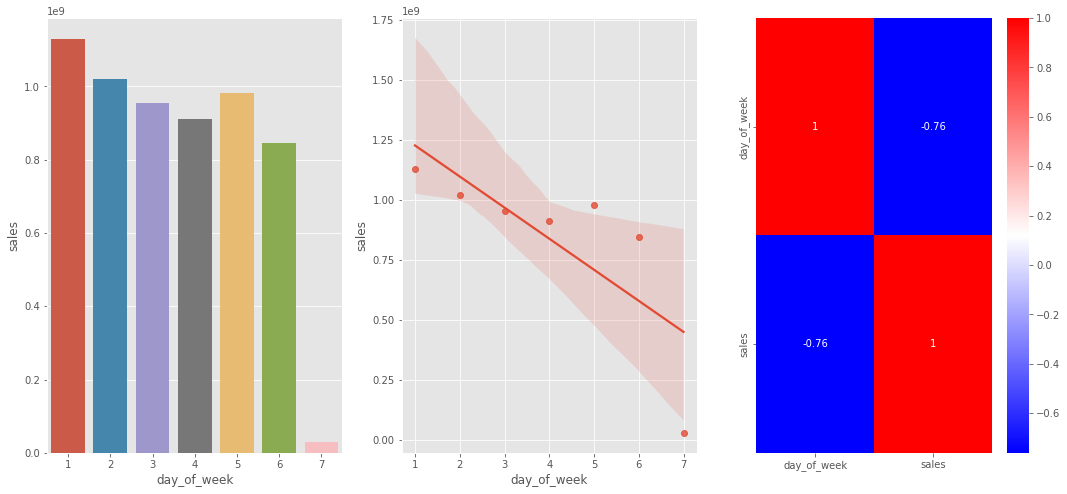

In [41]:
aux = df4.groupby('day_of_week', as_index=False)['sales'].sum()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux)

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(), annot=True, cmap='bwr');

### 12. Lojas deveriam vender menos durante os feriados escolares.
**Verdadeiro**, no geral, as lojas vendem menos em feriados escolares, porém, no mês de agosto, as lojas vendem mais e julho quase se equiparam

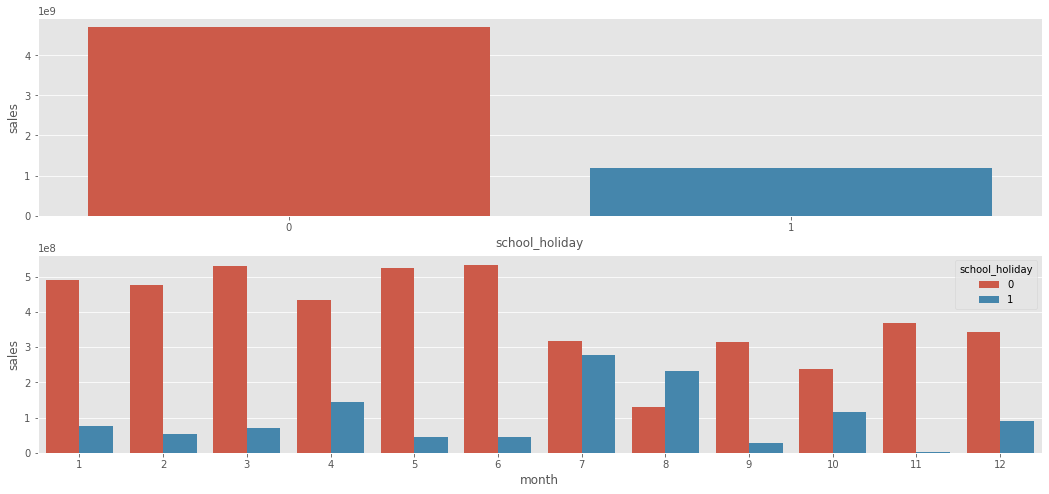

In [42]:
df4.head()
aux = df4.groupby('school_holiday', as_index=False)['sales'].sum()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux)

aux1 = df4.groupby(['month', 'school_holiday'], as_index=False)['sales'].sum()

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', data=aux1, hue='school_holiday');

### Resumo das hipóteses

In [43]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Verdadeira', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Verdadeira   Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 5.1 - Análise multivariada

### 5.1.1 - Análise numérica

<AxesSubplot:>

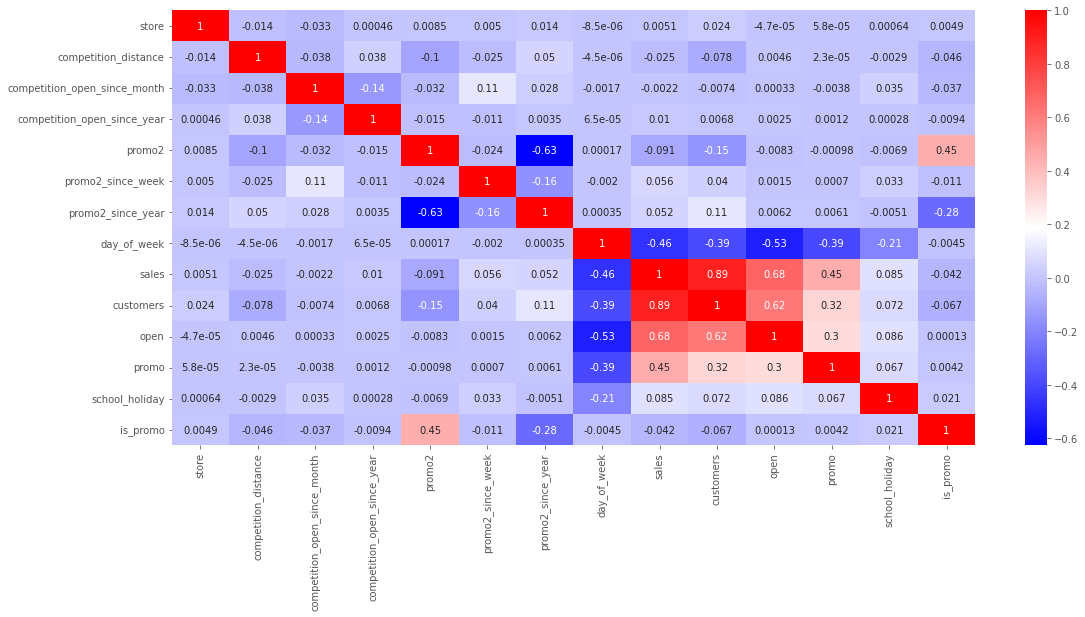

In [44]:
correlacao = num.corr()
sns.heatmap(correlacao, annot=True, cmap='bwr')

### 5.1.2 - Análise categórica

<AxesSubplot:>

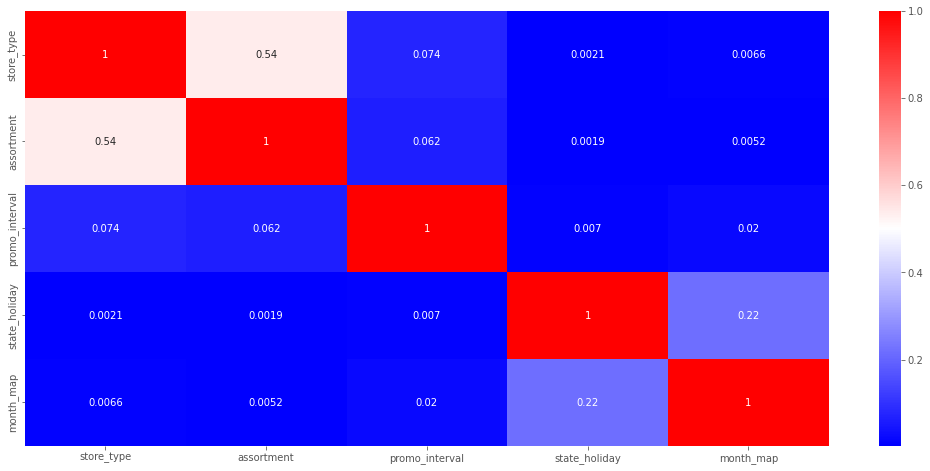

In [45]:
cat = cat.select_dtypes(include=['object'])
correlacao = corr_matrix(cat, cat.columns)
sns.heatmap(correlacao, annot=True, cmap='bwr')

# 6  - Preparação dos dados

In [46]:
df5 = df4.copy()

## 6.1 - Normalização

## 6.2 - Rescaling

In [47]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 6.3 - Transformação

### 6.3.1 - Encoding

In [48]:
le = LabelEncoder()

# story_type - Label Encoding
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment)

# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# year_week - Label Encoding
df5['year_week'] = le.fit_transform(df5['year_week'])

### 6.3.2 - Transformação da variável resposta

In [49]:
df5['sales'] = np.log1p(df5['sales'])

### 6.3.3 - Transformação de natureza

In [50]:
## Possuem natureza cíclica, exemplo, mês sempre vai de 1 até 12 e depois repete

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

# 7 - Seleção de features

In [51]:
df6 = df5.copy()

## 7.1 - Separação do dataframe entre treino e teste

In [52]:
df6.drop(['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week'], axis=1, inplace=True)

In [53]:
df6.groupby('store', as_index=False)['date'].max()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [54]:
# Dataset de treino
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# Dataset de teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

## 7.2 - Seleção de features com o Boruta

In [55]:
# # Treino e teste no Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # Definindo o RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # Definindo Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [56]:
# cols_selected = boruta.support_.tolist()

# # Melhores features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # Colunas não selecionadas
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

## 7.3 - Seleção manual das features

In [57]:
cols_selected_boruta = [
'store',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'promo',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos'
]

# Adicionando colunas
aux = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(aux)

# 8 - Modelos de Machine Learning

In [58]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 - Average model (modelo de média)

In [59]:
aux = x_test.copy()
aux['sales'] = y_test.copy()

# predição
aux2 = aux.groupby('store', as_index=False)['sales'].mean().rename(columns={'sales':'predictions'})
aux = pd.merge(aux, aux2, how='left', on='store')
y_pred_avg = aux['predictions']

# performance
resultado_avg = ml_error('Average Model', np.expm1(y_test), np.expm1(y_pred_avg))
resultado_avg

,model_name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 - Linear Regression model

In [60]:
# modelo
lr = LinearRegression().fit(x_train, y_train)

# predição
y_pred_lr = lr.predict(x_test)

# perfomance
resultado_lr = ml_error('Linear Regression Model', np.expm1(y_test), np.expm1(y_pred_lr))
resultado_lr

,model_name,MAE,MAPE,RMSE
0,Linear Regression Model,1867.089774,0.292694,2671.049215


## 7.3 -  Linear Regression Regularized Model - Lasso

In [61]:
# modelo
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# predição
y_pred_lrr = lrr.predict(x_test)

# perfomance
resultado_lrr = ml_error('Lasso', np.expm1(y_test), np.expm1(y_pred_lrr))
resultado_lrr

,model_name,MAE,MAPE,RMSE
0,Lasso,1891.704933,0.289106,2744.451612


## 7.4 -  Random Forest Regressor

In [ ]:
# # modelo
# rf = RandomForestRegressor(warm_start=True, n_estimators=100, n_jobs=1, random_state=42).fit(x_train, y_train)

# # predição
# y_pred_rf = rf.predict(x_test)

# # perfomance
# resultado_rf = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(y_pred_rf))
# resultado_rf

## 7.5 -  XGBoost Regressor

In [ ]:
# modelo
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=100,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9,
                            random_state=42).fit(x_train, y_train)

# predição
y_pred_xgb = xgb_model.predict(x_test)

# perfomance
resultado_xgb = ml_error('XGBost Regressor', np.expm1(y_test), np.expm1(y_pred_xgb))
resultado_xgb

## 7.6 - Comparando os resultados dos modelos

In [ ]:
resultado = pd.concat([resultado_avg, resultado_lr, resultado_lrr, resultado_xgb])
resultado.sort_values('RMSE')

In [59]:
x_training = X_train[cols_selected_boruta_full]

In [98]:
lr = LinearRegression()
cross_validation(lr, 'Linear Regression', x_training, 5, verbose=True)

1
2
3
4
5


,model_name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,mean: 2081.73 | std: +/- 295.63,mean: 0.3 | std: +/- 0.02,mean: 2952.52 | std: +/- 468.37
